In [1]:
import energyflow as ef
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = ef.zjets_delphes.load("Herwig", num_data=-1, pad=True, cache_dir='../data',
                                       source='zenodo', which='all',
                                       include_keys=None, exclude_keys=None)

In [13]:
gen_z = data['gen_Zs']
gen_jets = data['gen_jets']
sim_jets = data['sim_jets']
gen_particles = data['gen_particles']
sim_particles = data['sim_particles']
gen_lengths = data['gen_mults']
sim_lengths = data['sim_mults']

In [14]:
split = int(0.1 * len(gen_particles))
ttv_data = {'train': {'gen_particles': gen_particles[:8*split],
                      'gen_jets': gen_jets[:8*split],
                      'gen_z': gen_z[:8*split],
                      'sim_particles': sim_particles[:8*split],
                      'sim_jets': sim_jets[:8*split],
                      'gen_mults': gen_lengths[:8*split],
                      'sim_mults': sim_lengths[:8*split]},
            'test': {'gen_particles': gen_particles[8*split:9*split],
                     'gen_jets': gen_jets[8*split:9*split],
                     'gen_z': gen_z[8*split:9*split],
                     'sim_particles': sim_particles[8*split:9*split],
                     'sim_jets': sim_jets[8*split:9*split],
                     'gen_mults': gen_lengths[8*split:9*split],
                     'sim_mults': sim_lengths[8*split:9*split]},
            'val': {'gen_particles': gen_particles[9*split:],
                    'gen_jets': gen_jets[9*split:],
                    'gen_z': gen_z[9*split:],
                    'sim_particles': sim_particles[9*split:],
                    'sim_jets': sim_jets[9*split:],
                    'gen_mults': gen_lengths[9*split:],
                    'sim_mults': sim_lengths[9*split:]}
            }

In [5]:
import h5py

with h5py.File('../data/zplusjets.h5', 'w') as hf:
    for split in ttv_data:
        hf.create_group(split)
        for key in ttv_data[split]:
            hf[split].create_dataset(key, data=ttv_data[split][key])


In [19]:
with h5py.File('../data/zplusjets.h5', 'r') as hf:
    print(list(hf.keys()))
    print(list(hf['train'].keys()))


['test', 'train', 'val']
['gen_jets', 'gen_mults', 'gen_particles', 'gen_z', 'sim_jets', 'sim_mults', 'sim_particles']


In [29]:
print(f"Min particles per event: {min(gen_lengths)}")
print(f"Max particles per event: {max(gen_lengths)}")
print(f"Mean particles per event: {sum(gen_lengths)/len(gen_lengths)}")


Min particles per event: 1
Max particles per event: 152
Mean particles per event: 27.224888497388196


In [19]:
print(f"Min particles per event: {min(sim_lengths)}")
print(f"Max particles per event: {max(sim_lengths)}")
print(f"Mean particles per event: {sum(sim_lengths)/len(sim_lengths)}")


Min particles per event: 1
Max particles per event: 118
Mean particles per event: 19.784297871432333


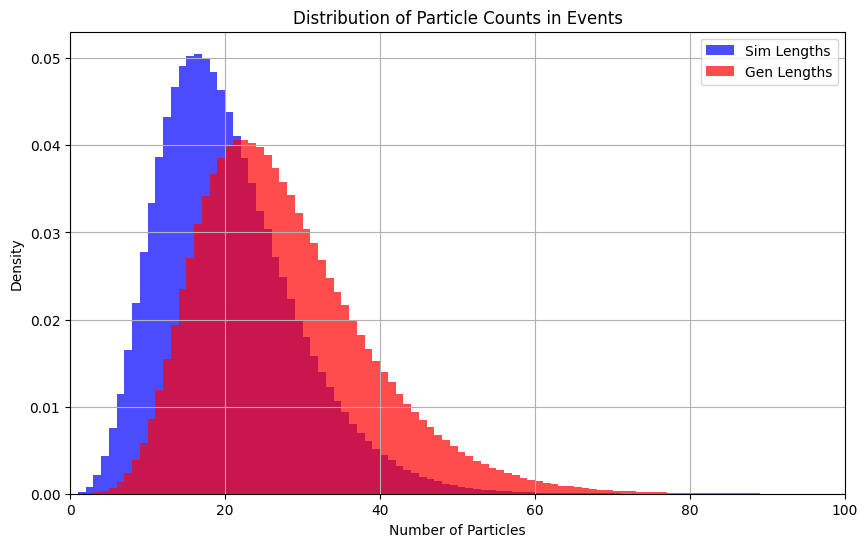

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(sim_lengths, bins=range(0,101), density=True, alpha=0.7, color='blue', label='Sim Lengths')
plt.hist(gen_lengths, bins=range(0,101), density=True, alpha=0.7, color='red', label='Gen Lengths')
plt.xlabel('Number of Particles')
plt.ylabel('Density')
plt.title('Distribution of Particle Counts in Events')
plt.xlim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


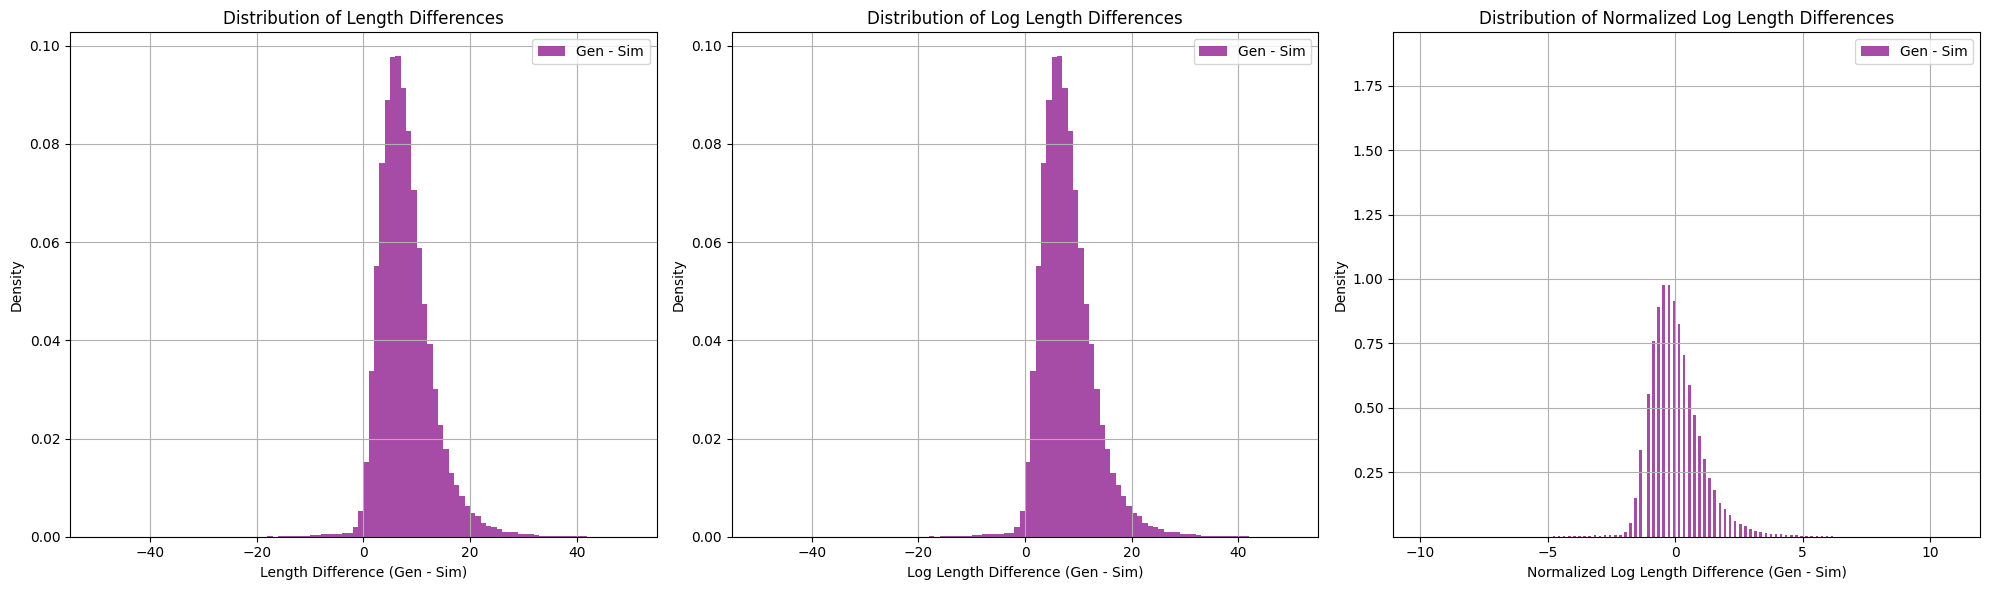

In [17]:
# Calculate length differences between gen and sim for each event
length_diffs = np.array(gen_lengths) - np.array(sim_lengths)
# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Regular histogram
ax1.hist(length_diffs, bins=range(-50,51), density=True, alpha=0.7, color='purple', label='Gen - Sim')
ax1.set_xlabel('Length Difference (Gen - Sim)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Length Differences')
ax1.grid(True)
ax1.legend()
log_length_diffs = length_diffs
# Log scale histogram
ax2.hist(log_length_diffs, bins=range(-50,51), density=True, alpha=0.7, color='purple', label='Gen - Sim')
ax2.set_xlabel('Log Length Difference (Gen - Sim)')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Log Length Differences')
ax2.grid(True)
ax2.legend()

normalized_log_length_diffs = (log_length_diffs - log_length_diffs.mean()) / log_length_diffs.std()
# Normalized log histogram
counts, bins, _ = ax3.hist(normalized_log_length_diffs, bins=np.arange(-10,11,0.1), density=True, alpha=0.7, color='purple', label='Gen - Sim')
max_count = np.max(counts)
ax3.set_ylim(max_count/1e6, max_count*2)  # Set reasonable log limits
ax3.set_xlabel('Normalized Log Length Difference (Gen - Sim)')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Normalized Log Length Differences')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()


In [34]:
# Find events where gen has significantly fewer particles than sim (gen-sim < -10)
large_deficit_mask = length_diffs < 0
large_deficit_count = np.sum(large_deficit_mask)

print(f"Number of events where gen has fewer particles than sim: {large_deficit_count}")
print(f"Percentage of total events: {100 * large_deficit_count / len(length_diffs):.2f}%")

# Extract the events with large deficits
deficit_gen_events = [gen_particles[i] for i in range(len(gen_particles)) if large_deficit_mask[i]]
deficit_sim_events = [sim_particles[i] for i in range(len(sim_particles)) if large_deficit_mask[i]]

Number of events where gen has fewer particles than sim: 1256
Percentage of total events: 1.26%


In [35]:
print('Particles ID in first gen event:', gen_particles[0][:, -1])
print('Particles ID in first sim event:', sim_particles[0][:, -1])

Particles ID in first gen event: [0.9 0.2 1.  0.2 0.2 0.1 0.1 0.3 0.  0.  0.1 0.2 0.  0.  0.1 0.3 0.  0.
 0.1 0.2 0.  0.1 0.2 0.  0. ]
Particles ID in first sim event: [0.1 0.2 0.2 0.1 0.2 0.1 0.2 0.1 0.2 0.1 0.2 0.  0.  0.  0.  0.  0.  0.3
 0.3]


In [36]:
pid_to_float = {
    22: 0.0,    # photon
    211: 0.1,   # pi+
    -211: 0.2,  # pi-
    130: 0.3,   # K0_L
    11: 0.4,    # e-
    -11: 0.5,   # e+
    13: 0.6,    # mu-
    -13: 0.7,   # mu+
    321: 0.8,   # K+
    -321: 0.9,  # K-
    2212: 1.0,  # proton
    -2212: 1.1, # anti-proton
    2112: 1.2,  # neutron
    -2112: 1.3  # anti-neutron
}

pid_to_name = {
    22: "gamma",
    211: "pi^+",
    -211: "pi^-",
    130: "K_0^L",
    11: "e^-",
    -11: "e^+",
    13: "mu^-",
    -13: "mu^+",
    321: "K^+",
    -321: "K^-",
    2212: "p",
    -2212: "anti-p",
    2112: "n",
    -2112: "anti-n"
}

float_to_pid = {v: k for k, v in pid_to_float.items()}

def map_pid_to_float(pid):
    """Convert particle ID to float representation"""
    try:
        float_id = pid_to_float[pid]
    except KeyError:
        print(f"Unknown particle ID: {pid}")
        float_id = -1.0
    return float_id

def map_float_to_pid(float_val):
    """Convert float representation back to particle ID"""
    # Round to nearest 0.1
    rounded = round(float_val * 10) / 10
    try:
        pid = float_to_pid[rounded]
    except KeyError:
        print(f"Unknown float value: {float_val}")
        pid = 0
    return pid


In [37]:
# Count particle types in first gen event
gen_unique, gen_counts = np.unique(deficit_gen_events[0][:, -1], return_counts=True)
print("\nParticle counts in first generated event:")
for pid, count in zip(gen_unique, gen_counts):
    print(f"PDG ID {map_float_to_pid(pid)}, corresponding to {pid_to_name[map_float_to_pid(pid)]}: {count} particles")

# Count particle types in first sim event
sim_unique, sim_counts = np.unique(deficit_sim_events[0][:, -1], return_counts=True)
print("\nParticle counts in first simulated event:")
for pid, count in zip(sim_unique, sim_counts):
    print(f"PDG ID {map_float_to_pid(pid)}, corresponding to {pid_to_name[map_float_to_pid(pid)]}: {count} particles")


Particle counts in first generated event:
PDG ID 22, corresponding to gamma: 4 particles
PDG ID 211, corresponding to pi^+: 1 particles
PDG ID -211, corresponding to pi^-: 3 particles
PDG ID 130, corresponding to K_0^L: 2 particles
PDG ID 2112, corresponding to n: 1 particles
PDG ID -2112, corresponding to anti-n: 1 particles

Particle counts in first simulated event:
PDG ID 22, corresponding to gamma: 11 particles
PDG ID 211, corresponding to pi^+: 9 particles
PDG ID -211, corresponding to pi^-: 10 particles
PDG ID 130, corresponding to K_0^L: 4 particles


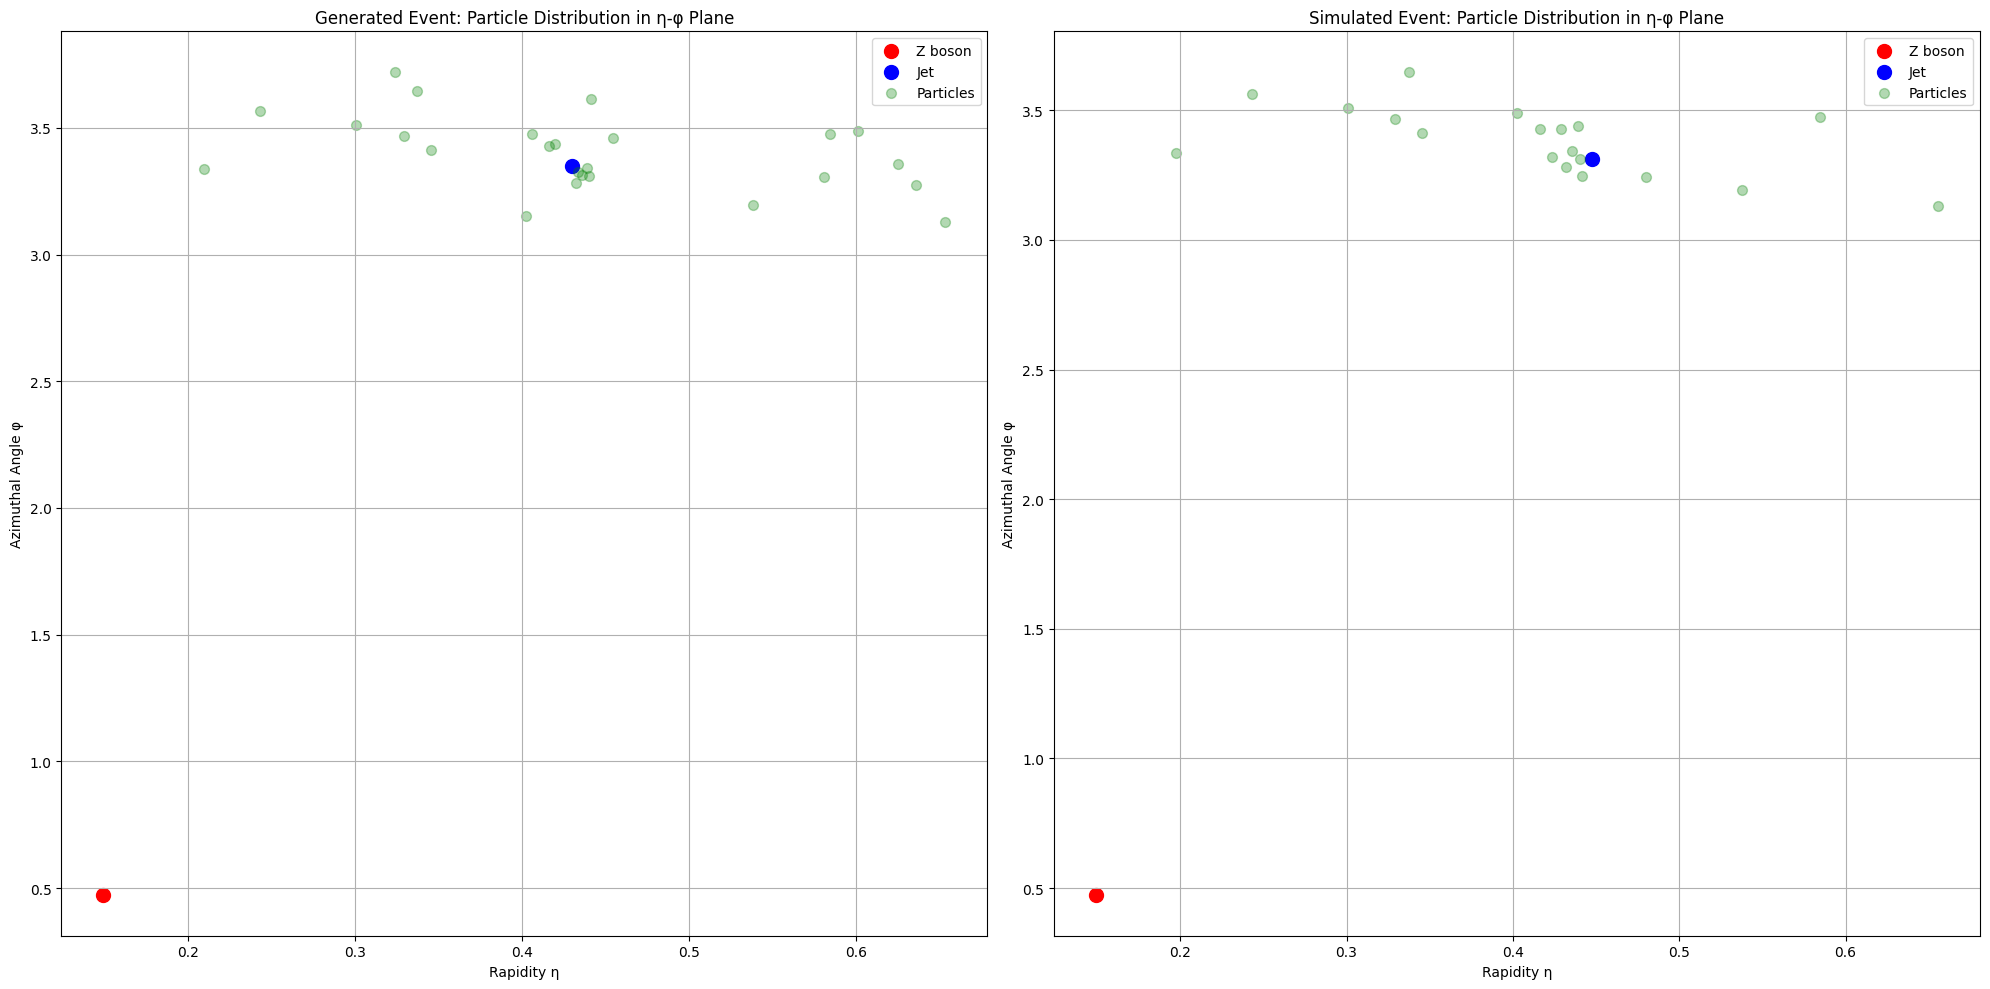

In [38]:
import matplotlib.pyplot as plt

# Extract data for first event - generated
first_gen_Z = gen_z[0]
first_gen_jet = gen_jets[0]
scaled_first_gen_particles = gen_particles[0]
first_gen_particles = np.zeros_like(scaled_first_gen_particles)
first_gen_particles[:, 0] = 100 * scaled_first_gen_particles[:, 0]
first_gen_particles[:, 1:3] = scaled_first_gen_particles[:, 1:3] + np.broadcast_to(first_gen_jet[np.newaxis, 1:3], scaled_first_gen_particles[:, 1:3].shape)

# Extract data for first event - simulated 
first_sim_jet = sim_jets[0]
first_sim_particles = sim_particles[0]
first_sim_particles[:, 0] = 100 * first_sim_particles[:, 0]
first_sim_particles[:, 1:3] = first_sim_particles[:, 1:3] + np.broadcast_to(first_sim_jet[np.newaxis, 1:3], first_sim_particles[:, 1:3].shape)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot generated event
ax1.scatter(first_gen_Z[1], first_gen_Z[2],
           color='red', label='Z boson', s=100)
ax1.scatter(first_gen_jet[1], first_gen_jet[2],
           color='blue', label='Jet', s=100)
ax1.scatter(first_gen_particles[:,1], first_gen_particles[:,2],
           color='green', alpha=0.3, label='Particles', s=50)
ax1.set_xlabel('Rapidity η')
ax1.set_ylabel('Azimuthal Angle φ')
ax1.set_title('Generated Event: Particle Distribution in η-φ Plane')
ax1.grid(True)
ax1.legend()

# Plot simulated event
ax2.scatter(first_gen_Z[1], first_gen_Z[2],
           color='red', label='Z boson', s=100)
ax2.scatter(first_sim_jet[1], first_sim_jet[2],
           color='blue', label='Jet', s=100)
ax2.scatter(first_sim_particles[:,1], first_sim_particles[:,2],
           color='green', alpha=0.3, label='Particles', s=50)
ax2.set_xlabel('Rapidity η')
ax2.set_ylabel('Azimuthal Angle φ')
ax2.set_title('Simulated Event: Particle Distribution in η-φ Plane')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [449]:
MAX_SEQ_LENGTH = 100

In [450]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

In [451]:
class ParticleTransformer(nn.Module):
    def __init__(
        self,
        d_model=256,
        nhead=8,
        num_layers=6,
        dim_feedforward=1024,
        dropout=0.1,
        max_seq_length=MAX_SEQ_LENGTH
    ):
        super().__init__()
        
        # Regular feature dimension (pT, eta, phi, pid) + stop token
        self.feature_dim = 4
        self.stop_token = torch.zeros(self.feature_dim)
        self.stop_token[-1] = -1.0  # Special value for stop token
        
        # Embeddings and transformer layers
        self.particle_embedding = nn.Linear(self.feature_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers
        )
        self.final_head = nn.Linear(d_model, self.feature_dim)
        
    def forward(self, sim_seq, gen_seq, tgt_mask):
        # Training forward pass (teacher forcing)
        sim_embedded = self.particle_embedding(sim_seq)
        gen_embedded = self.particle_embedding(gen_seq)
        
        sim_embedded = self.pos_encoding(sim_embedded)
        gen_embedded = self.pos_encoding(gen_embedded)
        
        decoded = self.transformer_decoder(
            gen_embedded.transpose(0, 1),
            sim_embedded.transpose(0, 1),
            tgt_mask=tgt_mask
        ).transpose(0, 1)
        
        return self.final_head(decoded)
    
    @torch.no_grad()
    def generate(self, sim_seq, max_length=None):
        """
        Generate a sequence of particles autoregressively until stop token or max_length
        """
        if max_length is None:
            max_length = MAX_SEQ_LENGTH
            
        batch_size = sim_seq.size(0)
        device = sim_seq.device
        
        # Initialize with first particle prediction
        current_seq = torch.zeros(batch_size, 1, self.feature_dim).to(device)
        
        # Generate particles one at a time
        for i in range(max_length - 1):  # -1 to leave room for stop token
            # Create mask for current sequence
            tgt_mask = generate_square_subsequent_mask(current_seq.size(1)).to(device)
            
            # Get next particle prediction
            sim_embedded = self.particle_embedding(sim_seq)
            current_embedded = self.particle_embedding(current_seq)
            
            sim_embedded = self.pos_encoding(sim_embedded)
            current_embedded = self.pos_encoding(current_embedded)
            
            decoded = self.transformer_decoder(
                current_embedded.transpose(0, 1),
                sim_embedded.transpose(0, 1),
                tgt_mask=tgt_mask
            ).transpose(0, 1)
            
            next_particle = self.final_head(decoded[:, -1:, :])
            
            # Check if stop token is predicted
            is_stop = (next_particle[:, :, -1] < -0.5).any(dim=1)
            if is_stop.any():
                break
                
            # Add predicted particle to sequence
            current_seq = torch.cat([current_seq, next_particle], dim=1)
        
        # Add stop token
        stop_token = self.stop_token.to(device).view(1, 1, -1).repeat(batch_size, 1, 1)
        current_seq = torch.cat([current_seq, stop_token], dim=1)
        
        return current_seq

In [452]:
class ParticleDataset(Dataset):
    def __init__(self, sim_particles, gen_particles, max_length=MAX_SEQ_LENGTH):
        self.sim_particles = sim_particles
        self.gen_particles = gen_particles
        self.max_length = max_length
        self.stop_token = torch.zeros(4)
        self.stop_token[-1] = -1.0  # Special value for stop token
        
    def pad_sequence(self, sequence, length):
        """Pad sequence to max_length with stop token followed by zeros"""
        if length >= self.max_length:
            # Truncate if longer than max_length and add stop token
            padded = sequence[:self.max_length-1]
            padded = np.vstack((padded, self.stop_token.numpy()))
            return padded
        else:
            # Add stop token and zero padding
            padded = np.vstack((sequence, self.stop_token.numpy()))
            padding = np.zeros((self.max_length - length - 1, sequence.shape[1]))
            return np.vstack((padded, padding))
    
    def __getitem__(self, idx):
        # Get particles for this event
        sim = self.sim_particles[idx]
        gen = self.gen_particles[idx]
        
        # Store original lengths
        sim_length = len(sim)
        gen_length = len(gen)
        
        # Pad sequences
        sim_padded = self.pad_sequence(sim, sim_length)
        gen_padded = self.pad_sequence(gen, gen_length)
        
        return {
            'sim_features': torch.FloatTensor(sim_padded),
            'gen_features': torch.FloatTensor(gen_padded),
            'sim_length': min(sim_length + 1, self.max_length),  # +1 for stop token
            'gen_length': min(gen_length + 1, self.max_length)   # +1 for stop token
        }
    
    def __len__(self):
        return len(self.sim_particles)


In [453]:
def generate_square_subsequent_mask(sz):
    """Generate a square mask for the sequence. The masked positions are filled with float('-inf').
    Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [454]:
def compute_loss(pred, target, target_lengths):
    """
    Compute loss while handling sequences of different lengths
    
    Args:
        pred: Model predictions [batch_size, pred_seq_len, feature_dim]
        target: Target values [batch_size, target_seq_len, feature_dim]
        target_lengths: Target sequence lengths including stop token [batch_size]
    """
    batch_size = pred.size(0)
    device = pred.device
    
    total_loss = 0
    for i in range(batch_size):
        # Find actual lengths (up to stop token) for both sequences
        pred_stop_pos = (pred[i, :, -1] < -0.5).nonzero()
        pred_length = pred_stop_pos[0].item() + 1 if len(pred_stop_pos) > 0 else pred.size(1)
        target_length = target_lengths[i].item()
        
        # Get sequences up to their respective lengths
        pred_seq = pred[i, :pred_length]
        target_seq = target[i, :target_length]
        
        # Compute length penalty (encourage correct sequence length)
        # length_diff = abs(pred_length - target_length)
        # length_penalty = length_diff * 0.1  # Adjustable weight
        
        # Compute content loss on the overlapping part
        min_length = min(pred_length, target_length)
        content_loss = F.mse_loss(
            pred_seq[:min_length], 
            target_seq[:min_length],
            reduction='mean'
        )
        
        # If prediction is longer, add loss for extra particles
        if pred_length > target_length:
            extra_loss = torch.mean(pred_seq[target_length:pred_length].pow(2))
            content_loss = content_loss + extra_loss  # Adjustable weight
        
        # Combine losses
        total_loss += content_loss #+ length_penalty
    
    return total_loss / batch_size

In [455]:
# 1. Prepare the data
# Convert particle IDs to float values
processed_gen_particles = data['gen_particles']
processed_sim_particles = data['sim_particles']

# 2. Create train/validation split
num_events = len(processed_gen_particles)
train_size = int(0.8 * num_events)
indices = np.random.permutation(num_events)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_gen = [processed_gen_particles[i] for i in train_indices]
train_sim = [processed_sim_particles[i] for i in train_indices]
val_gen = [processed_gen_particles[i] for i in val_indices]
val_sim = [processed_sim_particles[i] for i in val_indices]

# 3. Create datasets and dataloaders
train_dataset = ParticleDataset(train_sim, train_gen)
val_dataset = ParticleDataset(val_sim, val_gen)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# 4. Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = ParticleTransformer(
    d_model=256,
    nhead=8,
    num_layers=6,
    dim_feedforward=1024,
    dropout=0.1,
    max_seq_length=MAX_SEQ_LENGTH
)

# 5. Training configuration
num_epochs = 100
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


training_stats = []

try:
    for epoch in range(num_epochs):
        epoch_stats = {'epoch': epoch + 1}
        
        # Training phase
        model.train()
        train_losses = []
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]') as train_pbar:
            for batch in train_pbar:
                # Move data to device
                sim_features = batch['sim_features'].to(device)
                gen_features = batch['gen_features'].to(device)
                gen_lengths = batch['gen_length'].to(device)

                tgt_mask = generate_square_subsequent_mask(gen_features.size(1)).to(device)
                pred = model(sim_features, gen_features, tgt_mask)

                loss = compute_loss(pred, gen_features, gen_lengths)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_losses.append(loss.item())
                train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Validation phase
        model.eval()
        val_losses = []
        generation_losses = []
        
        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]') as val_pbar:
                for batch in val_pbar:
                    sim_features = batch['sim_features'].to(device)
                    gen_features = batch['gen_features'].to(device)
                    gen_lengths = batch['gen_length'].to(device)
                    
                    # Teacher forcing validation
                    tgt_mask = generate_square_subsequent_mask(gen_features.size(1)).to(device)
                    pred = model(sim_features, gen_features, tgt_mask)
                    loss = compute_loss(pred, gen_features, gen_lengths)
                    val_losses.append(loss.item())
                    
                    # Generation validation
                    generated_seqs = model.generate(sim_features)
                    gen_loss = compute_loss(generated_seqs, gen_features, gen_lengths)
                    generation_losses.append(gen_loss.item())
                    
                    val_pbar.set_postfix({'val_loss': f'{loss.item():.4f}', 'gen_loss': f'{gen_loss.item():.4f}'})
        
        # Calculate epoch statistics
        epoch_stats.update({
            'train_loss': np.mean(train_losses),
            'val_loss': np.mean(val_losses),
            'generation_loss': np.mean(generation_losses)
        })
        training_stats.append(epoch_stats)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"Train Loss: {epoch_stats['train_loss']:.4f}")
        print(f"Validation Loss: {epoch_stats['val_loss']:.4f}")
        print(f"Generation Loss: {epoch_stats['generation_loss']:.4f}")
        
        # Learning rate scheduling
        scheduler.step(epoch_stats['val_loss'])
        
        # Early stopping check
        if epoch_stats['val_loss'] < best_val_loss:
            best_val_loss = epoch_stats['val_loss']
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, 'best_particle_transformer.pt')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break

except KeyboardInterrupt:
    print("\nTraining interrupted by user")

finally:
    # Save training statistics
    import pandas as pd
    stats_df = pd.DataFrame(training_stats)
    stats_df.to_csv('training_stats.csv', index=False)
    
    # Plot training curves
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(stats_df['epoch'], stats_df['train_loss'], label='Train Loss')
    plt.plot(stats_df['epoch'], stats_df['val_loss'], label='Validation Loss')
    plt.plot(stats_df['epoch'], stats_df['generation_loss'], label='Generation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    plt.savefig('training_history.png')
    plt.close()

Using device: cpu


Epoch 1/100 [Train]:  59%|█████▉    | 148/250 [02:09<01:26,  1.18it/s, loss=0.0078][E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
Epoch 1/100 [Train]:  59%|█████▉    | 148/250 [02:10<01:29,  1.14it/s, loss=0.0078]


Training interrupted by user


KeyError: 'epoch'

<Figure size 1000x600 with 0 Axes>

In [421]:
# Load best model
checkpoint = torch.load('best_particle_transformer.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}")

Loaded best model from epoch 0 with validation loss 0.0007
